# Cloud labeling


This notebook reads in MOD02 and M0D35 data for a list of dates and generates images. This enables the user to label and save open and closed patches for the purpose of creating input data for a deep learning model. 

## Load Module

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
from pyhdf.SD import SD, SDC

In [2]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
homedir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [3]:
sys.path.insert(1,os.path.join(sys.path[0],homedir)) # this line helps you to use your own functinos in another directory
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

In [4]:
#returns the coded date in the format of year, and days after January 1st
#e.g. January 1, 2001 -- > 2001015
def get_coded_date(date):
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    leap_years = [2000, 2004, 2008, 2012]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:])
    days = day
    if month != 1:
        calendar = days_per_month
        if year in leap_years:
            calendar = days_per_month_leap
        for m in range(month - 1):
            days += calendar[m]
    return str(year * 1000 + days)

### Load dates 

In [5]:
# enter name of text file containing the dates
file_name = "/home/rubywerman/clouds/src_analysis/dates/label1.txt"
text_file = open(file_name, "r")
dates = text_file.read().split('\n')

The `Picture` object makes it simple to store the date, MOD02, and MOD35 data for each date

In [6]:
class Picture:
    def __init__(self, date, mod02_patches, vhdf_array, plot):
        self.date = date
        self.mod02_patches = mod02_patches
        self.vhdf_array = vhdf_array
        self.plot = plot
picture_dict = {}

The following function is used to load in the MOD02, MOD35, and coded date from your directories

In [ ]:
#select directory path for given date
def get_data(d):
    return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))

## Generate image

The following function `generate_image(d)` takes in a date and creates a cloud image using MOD02 and MOD35 data. The function also adds the image to a dictionary of cloud images. Red squares overlay the image, noting patches that have over .3 percent cloud coverage (this threshold can be changed below by editing the value of `thres`. 

In [ ]:
def generate_image(d):
    #load in the MOD02, MOD35, and coded date for the given date
    mod02_hdfdir, mod35_hdfdir, date = get_data(d)

    ### genetate numpy array for mod02, mod35 data
    mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
    clouds_mask_img = gen_mod35_img_single(hdf_datadir=mod35_hdfdir, date=date)

    # generate patch
    ## NO normalization to preserve original radiance strength 
    mod02_patches = _gen_patches(mod02_img, normalization=False)

    # cloud patches with at least ${thres} percent of cloud flag within patch
    thres = 0.3 # range [0.0 - 1.0] floating points. 0.3 is optimal
    clouds_patches_list, clouds_xy_list = const_clouds_array(mod02_patches, clouds_mask_img, thres=thres)

    # reconstruct img array from list
    ix, iy = mod02_patches.shape[:2]
    cimg_array = np.zeros((ix,iy)).astype(np.float64)
    cimg_array[:,:] = np.nan
    for idx, (x,y) in enumerate(clouds_xy_list):
        cimg_array[x,y] = 0  # input is 0 if there is a cloud (0 corresponds to color-list index afterwords)

    # load visible band (band 1 out of 36)
    hdf_datadir = mod02_hdfdir
    vis_file = glob.glob(
            hdf_datadir+'/MOD021KM.A'+date+'.mosaic.061.*.EV_250_Aggr1km_RefSB_1.hdf'
        )[0]

    # get hdf data  
    vhdf = SD(vis_file, SDC.READ)

    # get sds (science data structure) data
    vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")

    # the vhdf_array data is essential in recreating the image
    vhdf_array, vis_band = mod02_proc_sds_single(vhdf_sds)
    
    #create the image
    fig = plt.figure(figsize=(12,12))

    # set params
    xmin, ymin = 0, 0
    xmax, ymax = vhdf_array.shape
    linerange = 1 # every 10 patches, draw line

    patches   = mod02_patches
    img_array = cimg_array

    line_width = 2
    SHAPE = 128,128
    colors = ['#d62728']  # <-- here number of color-list is just 1 cimg_array[i,j] = {0, nan} 
    ax = plt.subplot(1,1,1)
    plt.hlines([i for i in range(0,xmax, 128*linerange)], xmin, xmax, "blue", linestyles='dashed')
    plt.vlines([i for i in range(0,ymax, 128*linerange)], ymin, ymax, "blue", linestyles='dashed')
    plt.imshow(vhdf_array, cmap='bone')
    plt.xticks( np.arange(0,xmax,128*linerange), 
               [str(idx*linerange)+' idx' for idx, i in enumerate( np.arange(0,xmax,128*linerange)) ] )
    plt.yticks( np.arange(0,ymax,128*linerange), 
               [str(idy*linerange)+' idy' for idy, i in enumerate( np.arange(0,ymax,128*linerange)) ] )

    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                ax.add_patch(mpl_patches.Rectangle(
                            (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                              width=SHAPE[0] - line_width * 2,
                              height=SHAPE[1] - line_width * 2,
                              linewidth=1,
                              edgecolor=colors[int(img_array[i,j])],
                              facecolor="none"                 
                            )
                    )
    #add the cloud image for the given date to a dictionary of cloud images
    picture_dict[d] = Picture(d, mod02_img, vhdf_array, plt)
    print(d)
    fig.tight_layout()
    plt.show()

The following cell iterates through the date list, generates the cloud images

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 1
2006-12-16


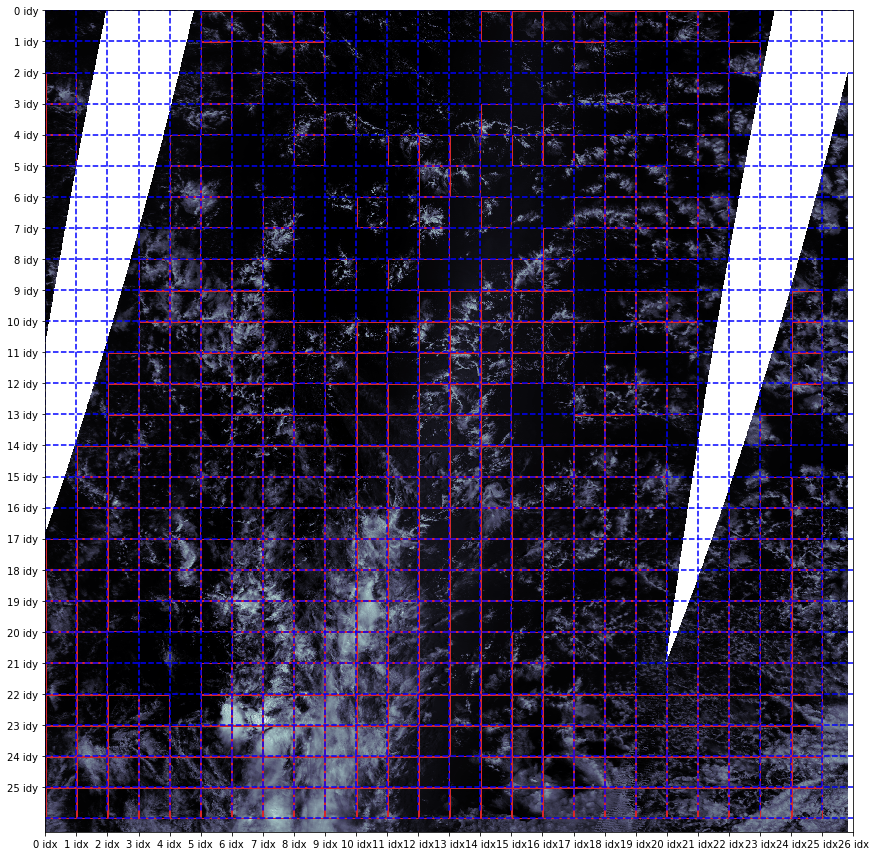

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 1
2006-12-16


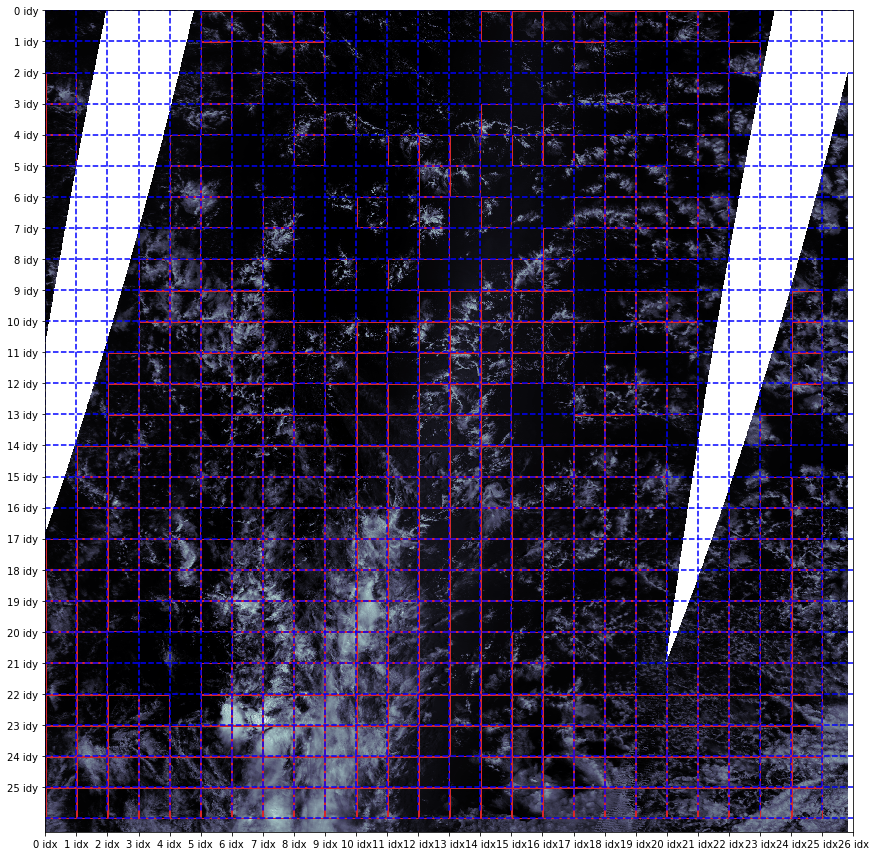

In [16]:
for d in dates[:2]:
    generate_image(x)

## Data Collection

Label the patches for each date below, make sure to update `selected_date` with the date you are currently labeling patches for

In [105]:
selected_date = "2013-07-09"
picture = picture_dict[selected_date]
closed_mod02 = []
closed_coord = []
open_mod02 = []
open_coord = []
mod02_imgg = picture.mod02_patches
mod35_imgg = picture.vhdf_array

The following functions are used to record open and closed patches in an image. Enter the coordinates in the form (yy1, yy2, xx1, xx2). The functions record the coordinate data (used later alongside the MOD35 data for the patch date to visualize individual patches in `visualize_patches.ipynb`) and the MOD02 data for the given patch coordinate, which is necessary for running the model and clustering.  

In [106]:
def oo(yy1, yy2, xx1, xx2, mod02_img=mod02_imgg):
    open_coord.append([yy1, yy2, xx1, xx2])
    open_mod02.append(_gen_patches(mod02_img[yy1*128:yy2*128, xx1*128:xx2*128], normalization=False))

def cc(yy1, yy2, xx1, xx2, mod02_img=mod02_imgg):
    closed_coord.append([yy1, yy2, xx1, xx2])
    closed_mod02.append(_gen_patches(mod02_img[yy1*128:yy2*128, xx1*128:xx2*128], normalization=False))

In the following cell, record your open and closed patches for the given date. Once your done labeling the image, run the output data cell. 

### Output data 

In [108]:
#output data
close_save(output_data)
open_save(output_data)
close_save_coords(output_data)
open_save_coords(output_data)

Update the save path so you save the files to the desired directory

In [49]:
from tempfile import TemporaryFile
def close_save(selected_date):
    if closed_coord:
        save_path02 = '/home/rubywerman/clouds/src_analysis/close_cells_mod02'
        name_of_file02 = "closed_" + selected_date
        completeName02 = os.path.join(save_path02, name_of_file02)  
        np.save(completeName02, closed_mod02)
        outfile02 = TemporaryFile()
        np.save(outfile02, closed_mod02)
        
        
def open_save(selected_date):
    if open_coord:
        save_path02 = '/home/rubywerman/clouds/src_analysis/open_cells_mod02'
        name_of_file02 = "open_" + selected_date
        completeName02 = os.path.join(save_path02, name_of_file02)  
        np.save(completeName02, open_mod02)
        outfile02 = TemporaryFile()
        np.save(outfile02, open_mod02)
        
def close_save_coords(selected_date):
    if closed_coord:
        sp = '/home/rubywerman/clouds/src_analysis/close_cells_coords'
        name = "closed_coords" + selected_date
        cn = os.path.join(sp, name)  
        np.save(cn, closed_coord)
        of = TemporaryFile()
        np.save(of, closed_coord)
           
def open_save_coords(selected_date):
    if open_coord:
        sp = '/home/rubywerman/clouds/src_analysis/open_cells_coords'
        name = "open_coords" + selected_date
        cn = os.path.join(sp, name)  
        np.save(cn, open_coord)
        of = TemporaryFile()
        np.save(of, open_coord)


def bad_data(selected_date):
    save_path = '/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile'
    name_of_file = "bad-data"
    completeName = os.path.join(save_path, name_of_file+".txt")
    file = open(completeName, "a")
    file.write(selected_date + "\n")
def oob_data(selected_date):
    save_path = '/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile'
    name_of_file = "out-of-bounds-data"
    completeName = os.path.join(save_path, name_of_file+".txt")
    file = open(completeName, "a")
    file.write(selected_date + "\n")

### Report open cell data

In [ ]:
def close_closed_img(selected_date):
        save_path35 = '/home/rubywerman/clouds/src_analysis/close_cells_mod35'
        name_of_file35 = "closed_35_" + selected_date
        completeName35 = os.path.join(save_path35, name_of_file35)  
        np.save(completeName35, clouds_mask_img)
        outfile35 = TemporaryFile()
        np.save(outfile35, clouds_mask_img)

def open_closed_img(selected_date):
        save_path35 = '/home/rubywerman/clouds/src_analysis/open_cells_mod35'
        name_of_file35 = "open_35_" + selected_date
        completeName35 = os.path.join(save_path35, name_of_file35)  
        np.save(completeName35, clouds_mask_img)
        outfile35 = TemporaryFile()
        np.save(outfile35, clouds_mask_img)

## Stuff to do, stuff to organize

Below is some unfinished code that will make it easier to label patches by only having to select patches, not write in coordinates

In [ ]:
def xgenerate_image(d):
    #load in the mod02, mod25, and coded date for the given date
    mod02_hdfdir, mod35_hdfdir, date = get_data(d)

    # generate numpy array for mod02, mod35 data
    mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
    clouds_mask_img = gen_mod35_img_single(hdf_datadir=mod35_hdfdir, date=date)

    # generate patches
    ## NO normalization to preserve original radiance strength 
    mod02_patches = _gen_patches(mod02_img, normalization=False)

    # cloud patches with at least ${thres} percent of cloud flag within patch
    thres = 0.3 # range [0.0 - 1.0] floating points. 0.3 is optimal
    clouds_patches_list, clouds_xy_list = const_clouds_array(mod02_patches, clouds_mask_img, thres=thres)

    # reconstruct img array from list
    ix, iy = mod02_patches.shape[:2]
    cimg_array = np.zeros((ix,iy)).astype(np.float64)
    cimg_array[:,:] = np.nan
    for idx, (x,y) in enumerate(clouds_xy_list):
        cimg_array[x,y] = 0  # input is 0 if there is a cloud (0 corresponds to color-list index afterwords)

    # load visible band (band 1 out of 36)
    hdf_datadir = mod02_hdfdir
    vis_file = glob.glob(
            hdf_datadir+'/MOD021KM.A'+date+'.mosaic.061.*.EV_250_Aggr1km_RefSB_1.hdf'
        )[0]

    # get hdf data  
    vhdf = SD(vis_file, SDC.READ)

    # get sds (science data structure) data
    vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")


    vhdf_array, vis_band = mod02_proc_sds_single(vhdf_sds)
    
    #create the figure
    fig = plt.figure(figsize=(50,125))

    patches   = mod02_patches
    img_array = cimg_array

    picture_dict[d] = Picture(d, mod02_img, vhdf_array, plt)
    
    aix = []
    for x in range(25):
        x1 = x
        x2 = x1 + 1
        for y in range(25):
            y1 = y
            y2 = y1 + 1
            aix.append((y1, y2, x1, x2))
            
    list_pics = []
    for i in range(25*25):
        p = aix[i]
        list_pics.append((aix[i], vhdf_array[p[0]*128:p[1]*128,p[2]*128:p[3]*128]))

    columns = 5
    rows = 125
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(list_pics[i-1][1])
    plt.show()